In [28]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
%matplotlib inline

In [185]:
# Picking a random number
secretnum = '101'
print(secretnum)

101


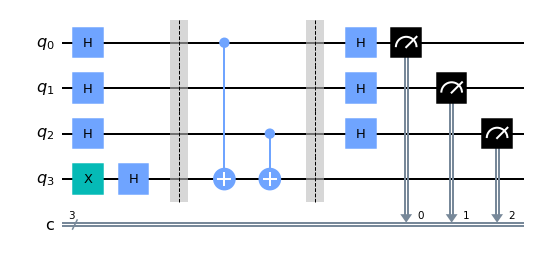

In [186]:
circuit = QuantumCircuit(len(secretnum)+1, len(secretnum))
# Oracle
circuit.h(range(len(secretnum)))
circuit.x(len(secretnum))
circuit.h(len(secretnum))
circuit.barrier()

# Build secret box, a cx gate means the secret value is a 1 and it goes left to right from down to up
for x, yesno in enumerate(reversed(secretnum)):
    if yesno == '1':
        circuit.cx(x, len(secretnum))
circuit.barrier()

#Fourier sampling - basically a reverse hadamard transform
circuit.h(range(len(secretnum)))

# Measuring circuit
circuit.measure(range(len(secretnum)),range(len(secretnum)))

circuit.draw(output='mpl')

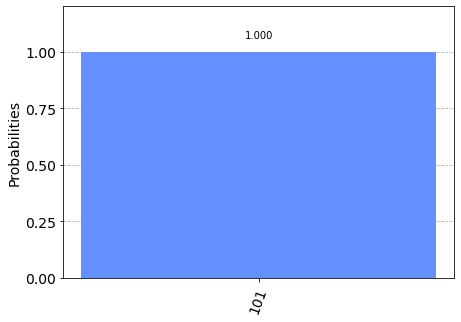

In [187]:
# Checking results of circuit in an ideal simulator
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1).result()
counts = result.get_counts()

plot_histogram(counts)

In [189]:
# Converting binary result to decimal
binval = 0
for num in counts:
    if num == '0' or '1':
        binval = num

intval = 0 
for x, yesno in enumerate(reversed(binval)):
    if yesno == '1':
        intval += 2 ** x
print(f"The number is {intval}")

The number is 5


In [60]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_santiago')

from qiskit.tools.monitor import job_monitor

ibmqfactory.load_account:WARNING:2020-11-14 20:30:36,645: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
# Running the circuit on an actual quantum computer
job = execute(circuit, backend=device, shots=1024)
job_monitor(job)

Job Status: job has successfully run


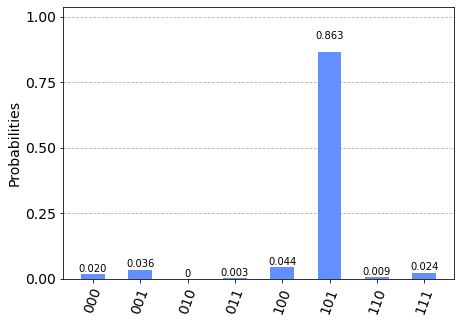

In [94]:
# Plotting the results
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

As observed above, quantum noise has given us measurements that are neither of the ideal states. In a purely theoretical sense, our circuit should output only 101 as observed above. To get a clearer picture of what the ideal measurements should actually look like, we can apply some post-processing to the results so that it filters out the 'invalid' states. This is what we call error mitigation.

We're going to split the quantum circuit into several quantum circuits so that each represent the computational basis state measurements of our overall circuit. These quantum circuits are what we call calibration circuits. So since we have a circuit with 3 measured qubits, we're going to break that into 8 computational basis states so that we can calibrate each one individually.

Note that the computational basis state of each circuit is the state label.

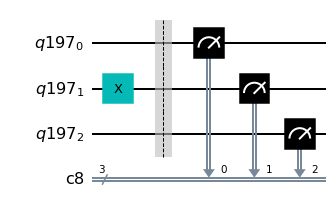

In [146]:
# Importing ignis to CALIBRATE CIRCUIT
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qubit_list=range(len(secretnum)), circlabel='measerrormitigationcal')
# Let's draw an arbitrary calibration circuit to look at an example
cal_circuits[2].draw(output= 'mpl')

In [147]:
# How many cal_circuits do we have?
len(cal_circuits)

8

In [166]:
cal_job = execute(cal_circuits,
                  backend=device,
                  shots=1024,
                  optimization_level=0,
                  )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5fb142f2c824d300139f4e7a
Job Status: job has successfully run


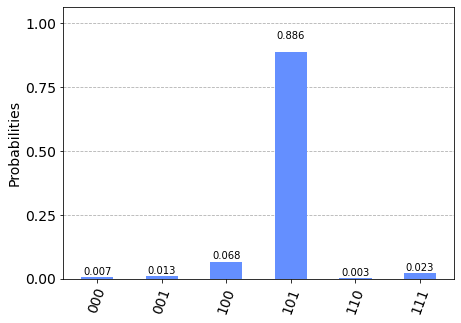

In [168]:
# Visualizing counts of an arbitrary calibration circuit
# Notice that we only measure the basis state 75-85% of the time, theoretically it should be 100%
plot_histogram(cal_results.get_counts(cal_circuits[5]))

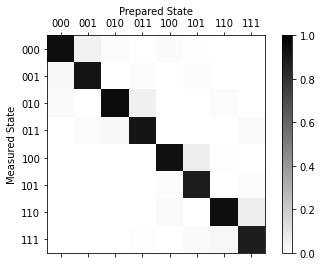

In [169]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [170]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(results)

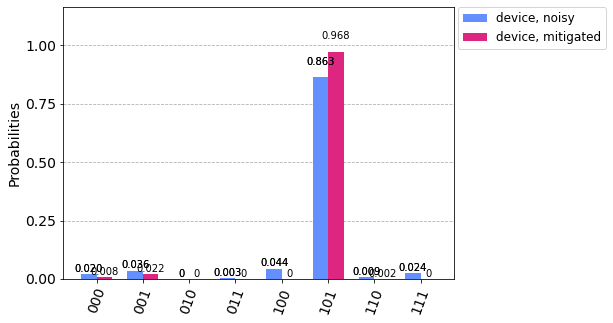

In [175]:
device_counts = results.get_counts()
mitigated_counts = mitigated_result.get_counts()
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

Hurrah! Virtually all of the unintended measurement states have been filtered out.

So we have now made a filter (inverse matrix) that can be applied to any 3 qubit circuit to filter out any off-target measurements. Note that our filter will work best when applied to circuits that have been run on the same quantum computer given that it's the noise model that we calibrated our filter for. Let's try applying our filter to the generic circuit I first showed you!